## Import

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import networkx as nx
from pgmpy.estimators import ConstraintBasedEstimator
from pgmpy.estimators.CITests import chi_square

## Load Data

### Taitanic

| 英語 | 日本語 |
|------|--------|
| Survived | 生存 |
| Pclass | チケットクラス |
| Name | 名前 |
| Sex | 性別 |
| Age | 年齢 |
| SibSp | 兄弟姉妹/配偶者の数 |
| Parch | 親/子供の数 |
| Ticket | チケット番号 |
| Fare | 運賃 |
| Embarked | 乗船した港 |

In [3]:
# df_original = pd.read_csv("./data/taitanic.csv")
# df_original

In [4]:
# categorical_columns = ["Survived", "Pclass", "SibSp", "Parch", "Sex", "Embarked"]
# categorical_df = df_original.loc[:, [*categorical_columns]]
# categorical_df.head()

In [5]:
# numerical_columns = ["Age", "Fare"]
# numerical_df = df_original.loc[:, [*numerical_columns]]
# numerical_df.head()

In [6]:
# numerical_df['Age'] = numerical_df['Age'].fillna(numerical_df['Age'].mean())
# numerical_df['Fare'] = numerical_df['Fare'].fillna(numerical_df['Fare'].mean())
# numerical_df.isna().sum()

In [7]:
# bin_df = pd.DataFrame([])
# n_bin = 3
# for name in numerical_df.columns:
#     bin_df[name], _ = pd.cut(numerical_df[name], n_bin, labels=np.arange(n_bin)+1, retbins=True)
# bin_df.head()

In [8]:
# bin_df = pd.concat([categorical_df, bin_df], axis=1)
# bin_df.head()

In [9]:
# bin_df = bin_df.loc[:, bin_df.columns[::-1].to_numpy()]
# bin_df = bin_df.dropna()
# bin_df

### california

| 英語 | 日本語 |
|------|--------|
| MedInc | 中央所得 |
| HouseAge | 住宅年数 |
| AveRooms | 平均部屋数 |
| AveBedrms | 平均寝室数 |
| Population | 人口 |
| AveOccup | 平均居住者数 |
| Latitude | 緯度 |
| Longitude | 経度 |
| MedHouseVal | 中央住宅価値 |

In [10]:
df_original = pd.read_csv("./data/california.csv")
df_original

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41,6.984127,1.023810,322,2.555556,37.88,-122.23,4.526
1,8.3014,21,6.238137,0.971880,2401,2.109842,37.86,-122.22,3.585
2,7.2574,52,8.288136,1.073446,496,2.802260,37.85,-122.24,3.521
3,5.6431,52,5.817352,1.073059,558,2.547945,37.85,-122.25,3.413
4,3.8462,52,6.281853,1.081081,565,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25,5.045455,1.133333,845,2.560606,39.48,-121.09,0.781
20636,2.5568,18,6.114035,1.315789,356,3.122807,39.49,-121.21,0.771
20637,1.7000,17,5.205543,1.120092,1007,2.325635,39.43,-121.22,0.923
20638,1.8672,18,5.329513,1.171920,741,2.123209,39.43,-121.32,0.847


In [11]:
bin_df = pd.DataFrame([])
n_bin = 3
for name in df_original.columns:
    bin_df[name], _ = pd.cut(df_original[name], n_bin, labels=np.arange(n_bin)+1, retbins=True)
bin_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,2,3,1,1,1,1,2,1,3
1,2,2,1,1,1,1,2,1,3
2,2,3,1,1,1,1,2,1,3
3,2,3,1,1,1,1,2,1,3
4,1,3,1,1,1,1,2,1,3


## Prepare Funcs

### Collect

In [12]:
class ConnectInfo:
    def __init__(self, p_val: float, col1: str, col2: str, cond_cols=[], p_threshold=0.05):
        self.is_connect = p_val < p_threshold
        self.p_val = p_val
        self.col1 = col1
        self.col2 = col2
        self.cond_cols = cond_cols
    
    def __str__(self):
        return f"{self.col1} , {self.col2} | {self.cond_cols} -> {self.is_connect} [{self.p_val:.2f}]"
    
    def __repr__(self):
        return f"{self.col1} , {self.col2} | {self.cond_cols} -> {self.is_connect} [{self.p_val:.2f}]"

In [13]:
class ConnectChecker:
    def __init__(self, est, p_threshold=0.01):
        self._est = est
        self._p_threshold = p_threshold
        
    def check(self, col1, col2, cond_cols=[]):
        _, p_val =  chi_square(X=col1, Y=col2, Z=cond_cols, data=self._est.data, state_names=self._est.state_names)
        connect_info = ConnectInfo(p_val, col1, col2, cond_cols=cond_cols, p_threshold=self._p_threshold)
        return connect_info
    
    def check_and_add(self, disconnect_infos, connect_df, col1, col2, cond_cols=[]):
        if not connect_df.loc[col1, col2]:
            return
        info = self.check(col1, col2, cond_cols=cond_cols)
        print(info)
        if not info.is_connect:
            disconnect_infos.append(info)        

In [14]:
def get_combinations(elements):
    result = []
    for parsed_elements in itertools.combinations(elements, 2):
        remaining_elements = [ele for ele in elements if ele not in parsed_elements]
        result.append((*parsed_elements, remaining_elements))
    return result
    
# sample
sample_list = [0, 1, 2, 4]   
get_combinations(sample_list)

[(0, 1, [2, 4]),
 (0, 2, [1, 4]),
 (0, 4, [1, 2]),
 (1, 2, [0, 4]),
 (1, 4, [0, 2]),
 (2, 4, [0, 1])]

In [15]:
def collect_disconnect_infos(n_dim, disconnect_infos, connect_df, connect_checker, current_cols=[], start=0):
    df_columns = connect_df.columns.to_numpy()
    
    if len(current_cols) == n_dim+2:
        combs = get_combinations(current_cols)
        for a, b, cs in combs:
            connect_checker.check_and_add(disconnect_infos, connect_df, a, b, cs)
        return
    
    for i in range(start, len(df_columns)):
        next_cols = current_cols + [df_columns[i]]
        collect_disconnect_infos(n_dim, disconnect_infos, connect_df, connect_checker, next_cols, i + 1)

### Apply

In [16]:
def generate_xxxxxs(n_dim):
    permus = list(itertools.permutations(np.arange(n_dim) + 2))

    result = []
    for digits in permus:
        digits_str = f"0{''.join(map(str, digits))}1"
        result.append(digits_str)

    return result

# sample
generate_xxxxxs(3)

['02341', '02431', '03241', '03421', '04231', '04321']

In [17]:
def check_xxxxx(connect_df, cols, xxxxx) -> bool:
    pairs = [
        [
            int(xxxxx[i]), 
            int(xxxxx[i+1]),
        ] for i in range(len(xxxxx)-1)
    ]
    
    result = True
    for pair in pairs:
        pair.sort()
        a, b = pair
        is_connect = connect_df.loc[cols[a], cols[b]]
        result = result and is_connect        
        if not result:
            break
    
    return result

In [18]:
def check_connect(connect_df, cols, n_dim) -> bool:
    xxxxxs = generate_xxxxxs(n_dim)
    for xxxxx in xxxxxs:
        is_connect = check_xxxxx(connect_df, cols, xxxxx)
        if is_connect:
            return True
    return False

In [19]:
def apply_disconnect_infos(n_dim, disconnect_infos, connect_df):
    disconnect_infos.sort(key=lambda x: x.p_val, reverse=True)
    for info in disconnect_infos:
        cols = [info.col1, info.col2, *info.cond_cols]    
        if not check_connect(connect_df, cols, n_dim):
            continue

        print(info)
        connect_df.loc[info.col1, info.col2] = False

### Viz

In [20]:
def viz_network(connect_df, title):
    df_columns = connect_df.columns.to_numpy()
    
    connect_pairs = []
    for i, col1 in enumerate(df_columns[:-2]):
        for j in range(i + 1, len(df_columns)):
            col2 = df_columns[j]
            if connect_df.loc[col1, col2]:
                connect_pairs.append((col1, col2))

    G = nx.DiGraph()
    G.add_nodes_from(df_columns)
    G.add_edges_from(connect_pairs)

    pos = nx.circular_layout(G)

    plt.figure(figsize=(10, 7))
    nx.draw_networkx(G, pos, with_labels=True, arrows=False, node_size=3000, alpha=0.4, font_weight="bold")
    plt.title(title)
    plt.axis('off')

## MAIN

In [21]:
est = ConstraintBasedEstimator(bin_df)
connect_checker = ConnectChecker(est)

connect_dfs = []

### Init

In [22]:
df_columns = bin_df.columns.to_numpy()
connect_init_df = pd.DataFrame(data=False, index=df_columns, columns=df_columns, dtype=bool)

for i, col1 in enumerate(df_columns[:-1]):
    for j in range(i + 1, len(df_columns)):
        col2 = df_columns[j]
        connect_init_df.loc[col1, col2] = True

In [23]:
connect_dfs.append(connect_init_df)

### Loop

In [24]:
n_dim_total = 4

In [25]:
for n_dim in range(n_dim_total+1):
    
    print(f"==================== DIM{n_dim} ====================")
    disconnect_infos = []
    print()
    
    print(f"-------------------- COLECT --------------------")
    collect_disconnect_infos(n_dim, disconnect_infos, connect_dfs[-1], connect_checker)
    print()
    
    print(f"-------------------- APPLY --------------------")
    connect_dfs.append( connect_dfs[-1].copy() )
    apply_disconnect_infos(n_dim, disconnect_infos, connect_dfs[-1])
    print()
    print()

==================== DIM0 ====================

-------------------- COLECT --------------------
MedInc , HouseAge | [] -> True [0.00]
MedInc , AveRooms | [] -> False [0.99]
MedInc , AveBedrms | [] -> False [1.00]
MedInc , Population | [] -> False [0.20]
MedInc , AveOccup | [] -> True [0.00]
MedInc , Latitude | [] -> True [0.00]
MedInc , Longitude | [] -> True [0.00]
MedInc , MedHouseVal | [] -> True [0.00]
HouseAge , AveRooms | [] -> False [0.66]
HouseAge , AveBedrms | [] -> False [0.88]
HouseAge , Population | [] -> True [0.00]
HouseAge , AveOccup | [] -> False [0.56]
HouseAge , Latitude | [] -> True [0.00]
HouseAge , Longitude | [] -> True [0.00]
HouseAge , MedHouseVal | [] -> True [0.00]
AveRooms , AveBedrms | [] -> True [0.00]
AveRooms , Population | [] -> False [1.00]
AveRooms , AveOccup | [] -> False [1.00]
AveRooms , Latitude | [] -> True [0.00]
AveRooms , Longitude | [] -> False [0.90]
AveRooms , MedHouseVal | [] -> False [0.95]
AveBedrms , Population | [] -> False [1.00]
AveB

## Result

In [26]:
def highlight_true(val):
    background_color = 'green' if val == 1 else ''
    return f'background-color: {background_color}'

In [27]:
labels = ["init"]
for i in range(n_dim_total+1):
    labels.append(f"level{i}")

In [28]:
for label, connect_df in zip(labels, connect_dfs):
    print(f"=========================== {label} ===========================")
    display(connect_df.astype(int).style.applymap(highlight_true))
    print()

=========================== init ===========================


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,0,1,1,1,1,1,1,1,1
HouseAge,0,0,1,1,1,1,1,1,1
AveRooms,0,0,0,1,1,1,1,1,1
AveBedrms,0,0,0,0,1,1,1,1,1
Population,0,0,0,0,0,1,1,1,1
AveOccup,0,0,0,0,0,0,1,1,1
Latitude,0,0,0,0,0,0,0,1,1
Longitude,0,0,0,0,0,0,0,0,1
MedHouseVal,0,0,0,0,0,0,0,0,0



=========================== level0 ===========================


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,0,1,0,0,0,1,1,1,1
HouseAge,0,0,0,0,1,0,1,1,1
AveRooms,0,0,0,1,0,0,1,0,0
AveBedrms,0,0,0,0,0,0,0,0,0
Population,0,0,0,0,0,0,0,0,0
AveOccup,0,0,0,0,0,0,0,0,0
Latitude,0,0,0,0,0,0,0,1,1
Longitude,0,0,0,0,0,0,0,0,1
MedHouseVal,0,0,0,0,0,0,0,0,0



=========================== level1 ===========================


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,0,1,0,0,0,1,1,1,1
HouseAge,0,0,0,0,1,0,1,1,1
AveRooms,0,0,0,1,0,0,1,0,0
AveBedrms,0,0,0,0,0,0,0,0,0
Population,0,0,0,0,0,0,0,0,0
AveOccup,0,0,0,0,0,0,0,0,0
Latitude,0,0,0,0,0,0,0,1,1
Longitude,0,0,0,0,0,0,0,0,1
MedHouseVal,0,0,0,0,0,0,0,0,0



=========================== level2 ===========================


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,0,1,0,0,0,1,1,0,1
HouseAge,0,0,0,0,1,0,1,1,1
AveRooms,0,0,0,1,0,0,1,0,0
AveBedrms,0,0,0,0,0,0,0,0,0
Population,0,0,0,0,0,0,0,0,0
AveOccup,0,0,0,0,0,0,0,0,0
Latitude,0,0,0,0,0,0,0,1,1
Longitude,0,0,0,0,0,0,0,0,1
MedHouseVal,0,0,0,0,0,0,0,0,0



=========================== level3 ===========================


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,0,1,0,0,0,1,0,0,1
HouseAge,0,0,0,0,1,0,1,1,1
AveRooms,0,0,0,1,0,0,1,0,0
AveBedrms,0,0,0,0,0,0,0,0,0
Population,0,0,0,0,0,0,0,0,0
AveOccup,0,0,0,0,0,0,0,0,0
Latitude,0,0,0,0,0,0,0,1,1
Longitude,0,0,0,0,0,0,0,0,1
MedHouseVal,0,0,0,0,0,0,0,0,0



=========================== level4 ===========================


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,0,1,0,0,0,1,0,0,1
HouseAge,0,0,0,0,1,0,1,1,1
AveRooms,0,0,0,1,0,0,1,0,0
AveBedrms,0,0,0,0,0,0,0,0,0
Population,0,0,0,0,0,0,0,0,0
AveOccup,0,0,0,0,0,0,0,0,0
Latitude,0,0,0,0,0,0,0,1,1
Longitude,0,0,0,0,0,0,0,0,1
MedHouseVal,0,0,0,0,0,0,0,0,0


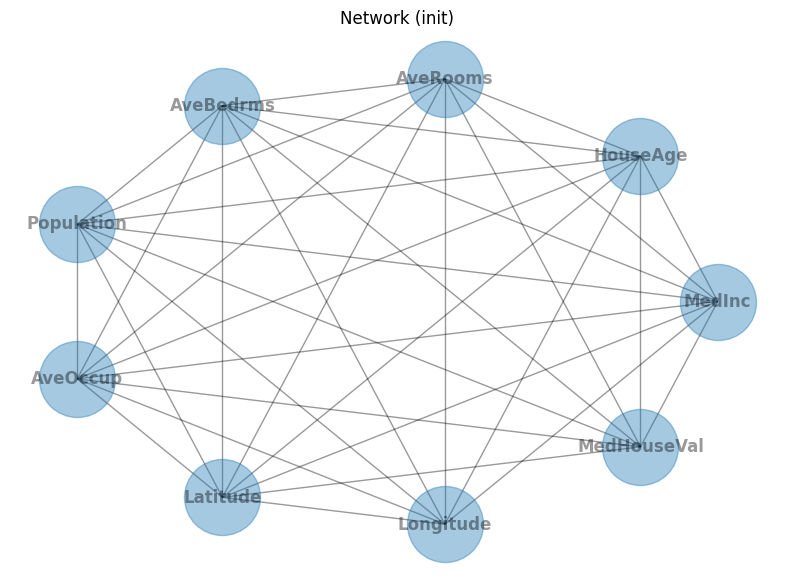

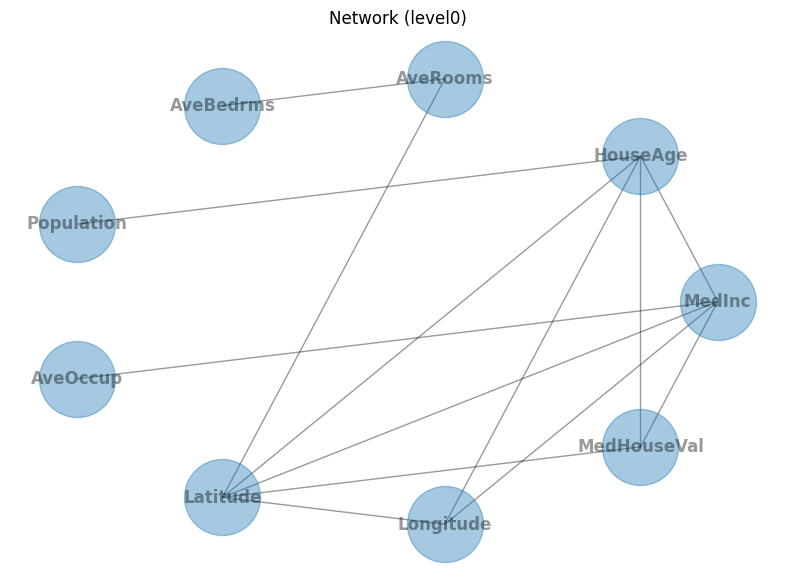

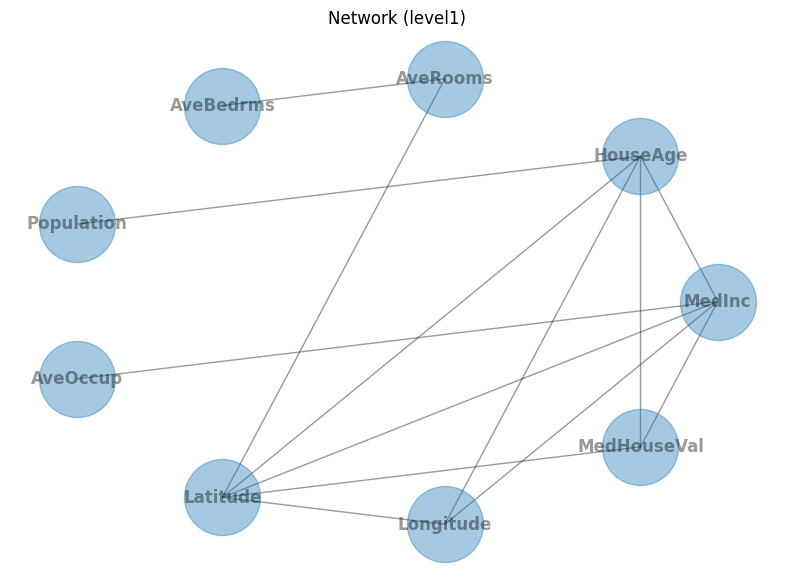

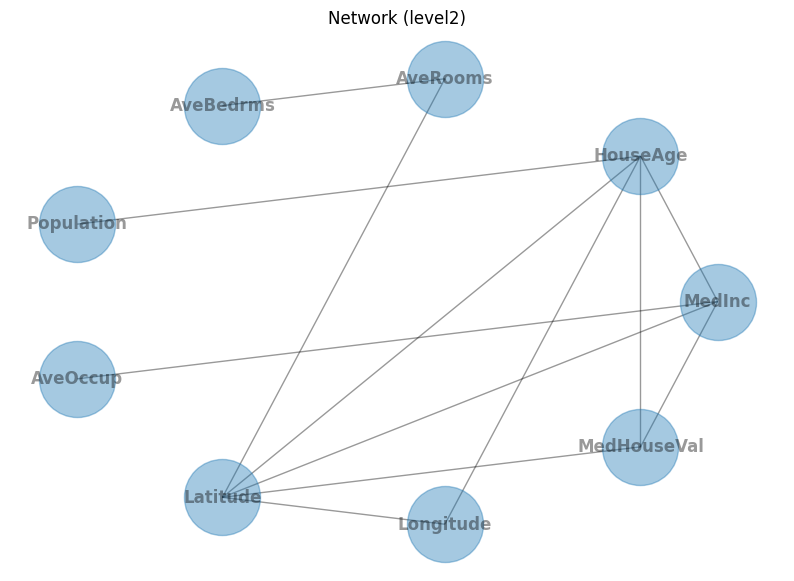

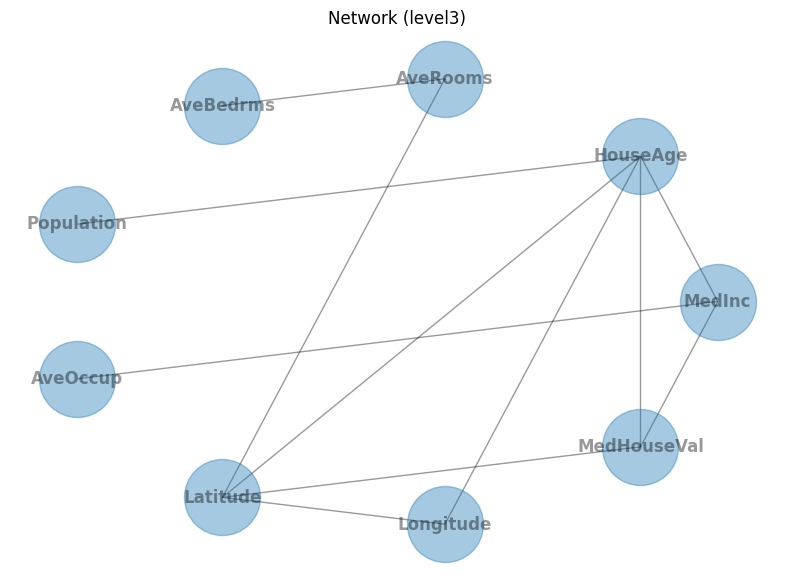

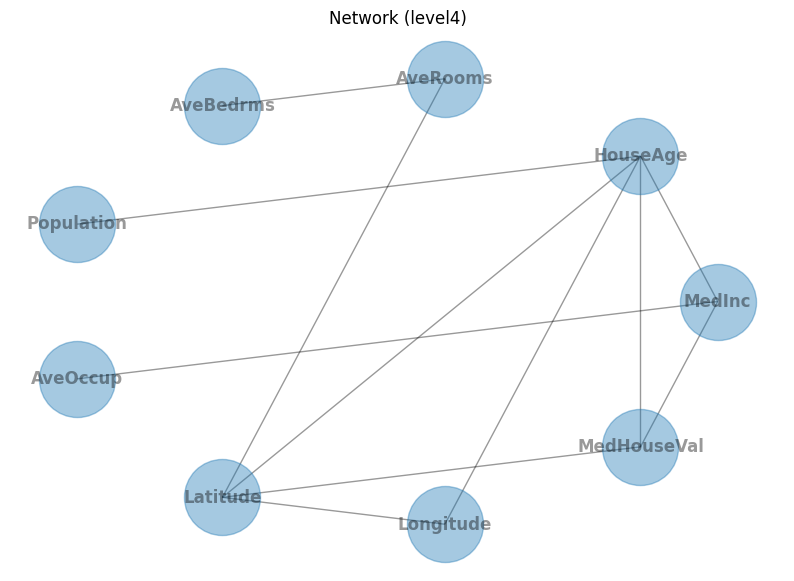

In [29]:
for label, connect_df in zip(labels, connect_dfs):
    viz_network(connect_df, f"Network ({label})")

## MEMO

In [30]:
# # 一次独立の確認
# disconnect_infos = []

# for i, col1 in enumerate(df_columns[:-2]):
#     for j in range(i + 1, len(df_columns)):
#         col2 = df_columns[j]
#         for k in range(j + 1, len(df_columns)):
#             col3 = df_columns[k]
            
#             is1to2 = connect_level0_df.loc[col1, col2]
#             is1to3 = connect_level0_df.loc[col1, col3]
#             is2to3 = connect_level0_df.loc[col2, col3]
#             if not (is1to2 and is1to3 and is2to3):
#                 print(f"{col1} {col2} {col3} skipped\n")
#                 continue
                
#             connect_info = connect_checker.check(col1, col2, [col3])
#             if not connect_info.is_connect:
#                 disconnect_infos.append(connect_info)
                
#             connect_info = connect_checker.check(col1, col3, [col2])
#             if not connect_info.is_connect:
#                 disconnect_infos.append(connect_info)
                
#             connect_info = connect_checker.check(col2, col3, [col1])
#             if not connect_info.is_connect:
#                 disconnect_infos.append(connect_info)
                
#             print(f"{col1} {col2} {col3} caluced\n")a

In [31]:
# # 一次独立の確認
# connect_level1_df = connect_level0_df.copy()

# for i, col1 in enumerate(df_columns[:-2]):
#     for j in range(i + 1, len(df_columns)):
#         col2 = df_columns[j]
#         for k in range(j + 1, len(df_columns)):
#             col3 = df_columns[k]
#             is1to2 = connect_level0_df.loc[col1, col2]
#             is2to3 = connect_level0_df.loc[col2, col3]
#             is3to1 = connect_level0_df.loc[col1, col3]
#             if not (is1to2 and is2to3 and is3to1):
#                 continue
                
#             print()
#             print(f"{col1} {col2} {col3}")
            
#             is_connect, independence = connect_checker.check(col1, col3, [col2])
#             if not is_connect:
#                 print(f"(1) {col1} {col3} is not connented o {col2}")
#                 connect_level1_df.loc[col1, col3] = False
#                 continue
                
#             is_connect, independence = connect_checker.check(col2, col3, [col1])
#             if not is_connect:
#                 print(f"(2) {col2} {col3} is not connented in {col1}")
#                 connect_level1_df.loc[col2, col3] = False
#                 continue
                
#             is_connect, independence = connect_checker.check(col1, col2, [col3])
#             if not is_connect:
#                 print(f"(3) {col1} {col2} is not connented in {col3}")
#                 connect_level1_df.loc[col1, col2] = False
#                 continue
            
#             print("Not Updated")

# connect_level1_df

In [32]:
# # 一次独立の確認
# connect_level1_df = connect_level0_df.copy()

# for i, col1 in enumerate(df_columns[:-2]):
#     for j in range(i + 1, len(df_columns)):
#         col2 = df_columns[j]
#         for k in range(j + 1, len(df_columns)):
#             col3 = df_columns[k]
#             is1to2 = connect_level0_df.loc[col1, col2]
#             is1to3 = connect_level0_df.loc[col1, col3]
#             is2to3 = connect_level0_df.loc[col2, col3]
#             if not (is1to2 and is1to3 and is2to3):
#                 continue
            
#             is1to2on3, independence_1to2on3 = connect_checker.check(col1, col2, [col3])
#             is1to3on2, independence_1to3on2 = connect_checker.check(col1, col3, [col2])
#             is2to3on1, independence_2to3on1 = connect_checker.check(col2, col3, [col1])
#             if is1to2on3 and is1to3on2 and is2to3on1:
#                 continue

#             independences = np.array([independence_1to2on3, independence_1to3on2, independence_2to3on1])
#             idx = np.argmax(independences)
#             if idx == 0:
#                 connect_level1_df.loc[col1, col2] = False
#             elif idx == 1:
#                 connect_level1_df.loc[col1, col3] = False
#             elif idx == 2:
#                 connect_level1_df.loc[col2, col3] = False

# connect_level1_df

In [33]:
# skel, seperating_sets = est.estimate_skeleton(significance_level=0.01)
# print("Undirected edges: ", skel.edges())

# pdag = est.skeleton_to_pdag(skel, seperating_sets)
# print("PDAG edges:", pdag.edges())

# model = est.pdag_to_dag(pdag)
# print("DAG edges:", model.edges())

# G = nx.DiGraph(pdag.edges())

# # グラフのレイアウトを計算
# pos = nx.circular_layout(G)

# # グラフを描画
# plt.figure(figsize=(10, 7))
# nx.draw_networkx(G, pos, with_labels=True, arrows=False, node_size=4000, alpha=0.4, font_weight="bold")
# plt.title("Directed Bayesian Network Visualization")
# plt.axis('off')
# plt.show()